база для реального вейвлета (ONLINEPIANO)

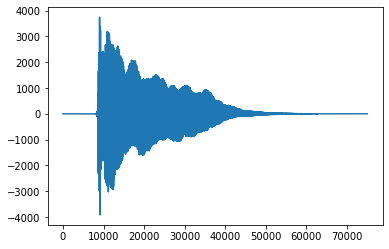

139


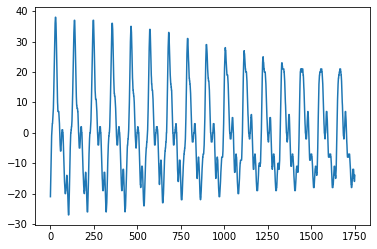

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
real_note = read('audio/onlinepiano/A4_trim.wav')
SAMPLING_FREQUENCY = real_note[0]
start = 52000
ending = start + 1751
real_note = real_note[1]
plt.plot(real_note)
plt.show()
real_wave = real_note[start:ending]
print(np.sum(real_wave))
plt.plot(real_wave)
plt.show()

Интеграл: -2.842170943040401e-14


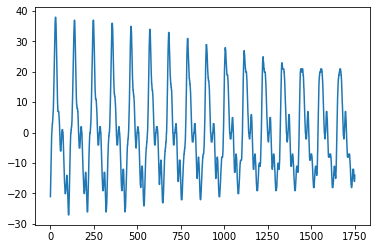

In [2]:
from scipy.fft import fft, ifft
fft_wave = fft(real_wave)
fft_wave[0] = 0 #первое число это интеграл!
ifft_wave = ifft(fft_wave)
print(f'Интеграл: {np.sum(np.real(ifft_wave))}')
plt.plot(np.real(ifft_wave))
plt.show()
onlinepiano_wavelet = np.real(ifft_wave)

база для реального вейвлета (FL Studio, Grand Piano)

ipykernel_launcher:1: WavFileWarning: Chunk (non-data) not understood, skipping it.


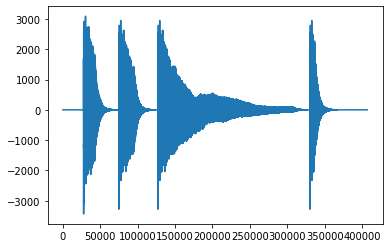

9552


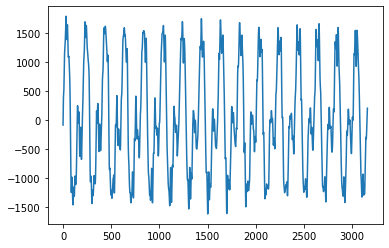

In [3]:
real_note = read('audio/flstudio/A4.wav')
SAMPLING_FREQUENCY = real_note[0]
real_note = real_note[1]
plt.plot(real_note)
plt.show()
start = 74501 +13328 + 40
ending = start + 1751 + 1700 -250 -40
real_wave = real_note[start:ending] #115000
print(np.sum(real_wave))
plt.plot(real_wave)
plt.show()

Интеграл: 1.4551915228366852e-11


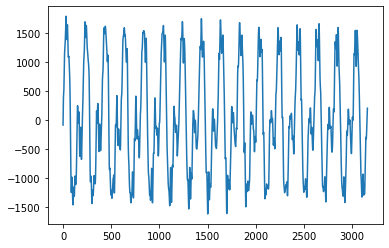

In [4]:
fft_wave = fft(real_wave)
fft_wave[0] = 0 #первое число это интеграл!
ifft_wave = ifft(fft_wave)
print(f'Интеграл: {np.sum(np.real(ifft_wave))}')
plt.plot(np.real(ifft_wave))
plt.show()
flstudio_wavelet = np.real(ifft_wave)

In [5]:
def piecewise_linear_wavelet(wavelet):
    def res(t):
        if t < -1 or t>=len(wavelet)-1: 
            return 0
        elif t<0:
            return wavelet[0]*abs(1-t)
        else:
            i = int(np.trunc(t))
            return wavelet[i] + (wavelet[i+1] - wavelet[i])*(t-i) #аппроксимация
    return res

def mother_wavelet_approximation(x):
    return piecewise_linear_wavelet(mother_wavelet)(x)

#они тут нулевые, чтобы чуть позже можно было выбрать материнский вейвлет - onlinepiano или flstudio
mother_wavelet = None
mother_wavelet_approximation_length = 0

In [6]:
def conv_piano_wavelet(scale):
    '''возвращает дочерний вейвлет с заданным scale - масштабом'''
    #модификатор. это понятно.
    modifier = np.power(2, (-scale/12), dtype=np.float64)

    #я интуитивно понимаю, что произошло внутри, но как это по-человечески описать?
    daughter_wavelet = lambda t: mother_wavelet_approximation(t/modifier)
    
    #длина матери * модификатор = длина ребенка. массив иксов длины ребенка.
    x = list(range(int(mother_wavelet_approximation_length*modifier)))
    
    #применяем функцию daughter_wavelet на иксы.
    return np.array(list(map(daughter_wavelet,x)))


#plt.plot(conv_piano_wavelet(scale=-48))
#plt.show()

In [7]:
piano_wavelets = ['onlinepiano', 'flstudio']
def choose_wavelet_origin(origin:str):
    assert origin in piano_wavelets, f"No wavelet with such origin! Available wavelets: {piano_wavelets}"
    
    global mother_wavelet, mother_wavelet_approximation_length
    if origin=='onlinepiano':
        mother_wavelet = onlinepiano_wavelet
        mother_wavelet_approximation_length = len(mother_wavelet)
    elif origin=='flstudio':
        mother_wavelet = flstudio_wavelet
        mother_wavelet_approximation_length = len(mother_wavelet)

# входной сигнал

ipykernel_launcher:5: WavFileWarning: Chunk (non-data) not understood, skipping it.


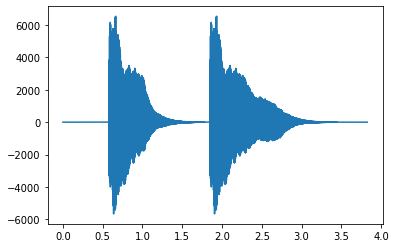

In [8]:
from scipy.io.wavfile import read
folder = 'audio/flstudio/'
file_name = 'A4_test'
file_format = '.wav'
test_signal = read(folder+file_name+file_format)
SAMPLING_FREQUENCY = test_signal[0]
test_signal = test_signal[1]
if len(test_signal.shape) == 2:
    #onlinepiano    
    choose_wavelet_origin('onlinepiano')
    assert real_wavelet != 0 and real_wavelet_approximation_length > 0, "Failed choosing wavelet"
    test_signal = test_signal[:,0]
else:
    #flstudio
    choose_wavelet_origin('flstudio')

time_array = np.arange(0,len(test_signal))/SAMPLING_FREQUENCY
plt.plot(time_array,test_signal)

In [9]:
%%time
from scipy.signal import correlate
from scipy.ndimage import median_filter
from scipy.ndimage import maximum_filter

def my_cwt(data, scales):
    #каждая строчка - результат свертки для вейвлета с этим scale
    if type(scales) != list and type(scales) != np.ndarray:
        scales = [scales]
    cwt_result = np.zeros((len(scales), len(data))) 
    for i in range(len(scales)):
        wave = conv_piano_wavelet(scales[i])
        #если длина ноты (пусть и 16 периодов) больше длины сигнала, то ее там точно нет
        if len(wave)>len(cwt_result[i]):
            cwt_result[i] = [0]*len(cwt_result[i])
        else:
            cwt_result[i] = correlate(data, wave, mode='same', method='fft')
            modifier = np.power(abs(np.power(2, (-scales[i]/12), dtype=np.float64)), -0.5)
            cwt_result[i] *= modifier
    #return cwt_result
    filtered_cwt = np.zeros(cwt_result.shape)
    for line_num in range(len(cwt_result)):
        filtered_cwt[line_num] = median_filter(maximum_filter(abs(cwt_result[line_num]),401),401)
    return filtered_cwt


widths = list(np.arange(-24,12.01))
cwt_result = my_cwt(test_signal,widths)

Wall time: 15.9 s


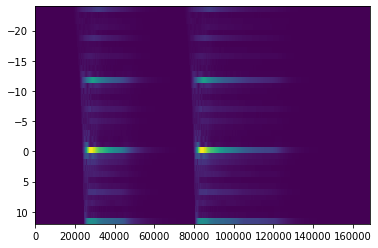

In [10]:
plt.imshow(cwt_result, aspect='auto', interpolation='none', 
            extent=[0, cwt_result.shape[1]-1, widths[-1], widths[0]])
plt.show()

чем выше строчка, тем сильнее у нее отклик. отличаются примерно на modifier

домножим каждую строчку на modifier, чтобы их выравнять

In [11]:
cwt_amplified = cwt_result
# widths_modified = np.power(1.1702675, (np.array(widths)/12))
# print(widths_modified)
# cwt_amplified = cwt_result * widths_modified[:,np.newaxis]
# plt.imshow(cwt_amplified, aspect='auto', interpolation='none',
#             extent=[0, cwt_amplified.shape[1]-1, widths[-1], widths[0]])
# plt.show()

In [12]:
%%time
#фильтруем вертикально-октавно
if len(widths)>13: #чтобы там вообще были октавы
    rows = list(range(len(widths))) #0->len(widths)
    cwt_vertical_octave_filtered = np.zeros_like(cwt_amplified)
    for column_num in range(len(cwt_amplified[0])):
        column = list(cwt_amplified[:,column_num])
        for row_num in range(0,12):
            #возьмем все значения через октаву
            octave_row_nums = rows[row_num::12]
            if len(octave_row_nums)>1:
                octave_values = np.take(cwt_amplified[:,column_num], octave_row_nums)
                #останутся только самые сильные значения
                octave_threshold = max(octave_values) * 0.95
                octave_values_filtered = [item if item > octave_threshold else 0 for item in octave_values]
                for row_num, value in zip(octave_row_nums, octave_values_filtered):
                    column[row_num] = value
        cwt_vertical_octave_filtered[:,column_num] = column
else:
    cwt_vertical_octave_filtered = cwt_amplified

Wall time: 22.5 s


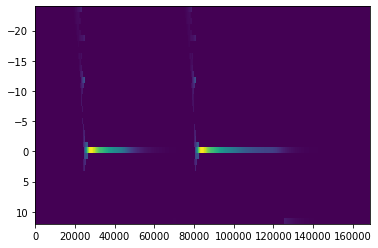

Wall time: 3.5 s


In [13]:
%%time
#фильтруем по максимуму вертикаль 

cwt_vertical_filtered = np.zeros_like(cwt_vertical_octave_filtered)
for column_num in range(len(cwt_vertical_filtered[0])):
    column_max_threshold = max(cwt_vertical_octave_filtered[:,column_num]) * 0.3
    cwt_vertical_filtered[:,column_num] = [item if item > column_max_threshold else 0 for item in cwt_vertical_octave_filtered[:,column_num]]

plt.imshow(cwt_vertical_filtered, aspect='auto', interpolation='none',
            extent=[0, cwt_amplified.shape[1]-1, widths[-1], widths[0]])
plt.show()

In [14]:
#возьмем производную, чтобы найти начала нот
def note_beginnings(cwt_row) -> np.ndarray:
    #получаем производную и фильтруем пики
    cwt_row_diff = abs(np.diff(cwt_row))
    cwt_row_diff_threshold = max(cwt_row_diff) * 0.25
    #фильтр порога по максимуму. останутся только резкие скачки между значениями
    cwt_row_diff_bin = [1 if item > cwt_row_diff_threshold else 0 for item in cwt_row_diff]
    #теперь ищем начала заметных единиц
    cwt_row_diff_bin_indices = list(np.nonzero(np.r_[1, np.diff(cwt_row_diff_bin)[:-1]])[0])
    lengths = cwt_row_diff_bin_indices.copy()
    min_interval = 5000 #минимальный интервал между началами нот
    if cwt_row_diff_bin[0] == 0:
        lengths[::2] = [0]*len(cwt_row_diff_bin_indices[::2])
    else:
        lengths[1::2] = [0]*len(cwt_row_diff_bin_indices[1::2])
    #получаем длины между единицами
    lengths_between_ones = np.append(lengths[:2], np.subtract(lengths[2:], lengths[:-2]))
    lengths_good_indices = np.where(lengths_between_ones > min_interval)[0]
    return np.take(cwt_row_diff_bin_indices, lengths_good_indices)

In [15]:
def count_frequency(scale):
    n0 = 440
    modifier = np.power(2, (-scale/12), dtype=np.float64)
    return round(n0/modifier,2)

-24.0: 0.07948304798589313
-23.0: 0.03025292830515173
-22.0: 0.03402520186704035
-21.0: 0.021180493227319207
-20.0: 0.031006421979526022
-19.0: 0.0753042418614754
-18.0: 0.018074985931691944
-17.0: 0.01374535650482042
-16.0: 0.035711455845343465
-15.0: 0.03844090423284313
-14.0: 0.04843708200499018
-13.0: 0.0973442381364123
-12.0: 0.28687352984352205
-11.0: 0.12587617500834394
-10.0: 0.07384159260477885
-9.0: 0.054502559511773276
-8.0: 0.056366791152064936
-7.0: 0.049093953592328085
-6.0: 0.03912377733792779
-5.0: 0.05157698270734378
-4.0: 0.06902292853791449
-3.0: 0.0875550926431506
-2.0: 0.12445179336075982
-1.0: 0.2792938052301234
0.0: 1.0
1.0: 0.26188118613184613
2.0: 0.12540253746508437
3.0: 0.09060990763752133
4.0: 0.06541485759857668
5.0: 0.0
6.0: 0.0
7.0: 2.295424204878704e-05
8.0: 0.0
9.0: 0.0
10.0: 0.0
11.0: 1.7109339782853616e-05
12.0: 0.08482796953926874


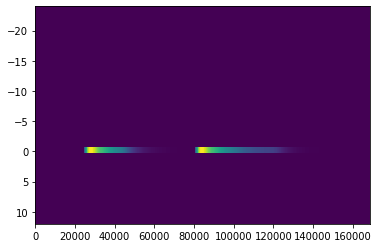

Wall time: 2.15 s


In [16]:
%%time
def note_noter(cwt_data) -> dict:
    MIN_LENGTH = 8000
    rows_maxes = [max(row) for row in cwt_data]
    NOTE_EXISTANCE_THRESHOLD = max(rows_maxes) * 0.44
    for num, row_max in enumerate(rows_maxes):
        print(f'{widths[num]}: {row_max/max(rows_maxes)}')
    noted_rows = np.array([1 if row_max>=NOTE_EXISTANCE_THRESHOLD else 0 for row_max in rows_maxes])
    noted_rows_indices = np.where(noted_rows==1)[0]

    cwt_data_filtered = np.zeros_like(cwt_data)
    for row in noted_rows_indices:
        cwt_data_filtered[row] = median_filter(maximum_filter(cwt_data[row],401),401)
    plt.imshow(cwt_data_filtered, aspect='auto', interpolation='none',
            extent=[0, cwt_data_filtered.shape[1]-1, widths[-1], widths[0]])
    plt.show()

    notes = {}
    for row in noted_rows_indices:
        freq = count_frequency(widths[row])
        beginnings = note_beginnings(cwt_data_filtered[row])

        for note_beginning_num in range(len(beginnings)):
            if note_beginning_num+1 >= len(beginnings):
                interval_end = len(cwt_amplified[0])-1
            else:
                interval_end = beginnings[note_beginning_num+1]
            interval = cwt_data_filtered[row][beginnings[note_beginning_num]:interval_end]
            #порог для остановки ноты
            interval_max = max(interval)
            interval_threshold = interval_max * 0.07

            #ищем место максимума в интервале - старт ноты
            for interval_idx in range(len(interval)):
                if interval[interval_idx] == interval_max:
                    break
            note_start = interval_idx
            #ищем ноль (место меньше interval_threshold) - конец ноты
            for interval_idx in range(note_start,len(interval)):
                if interval[interval_idx] < interval_threshold:
                    break
            note_end = interval_idx
            #длина ноты
            note_length = note_end - note_start
            if note_length < MIN_LENGTH: continue
            #переведем начало и конец ноты в систему отсчета всего сигнала
            note_start += beginnings[note_beginning_num]
            note_end += beginnings[note_beginning_num]
            
            note_info = {
                'start': note_start,
                'end': note_end,
                'length': note_length
            }
            if freq not in notes: notes[freq] = []
            notes[freq].append(note_info)
    return notes

notes = note_noter(cwt_vertical_filtered)

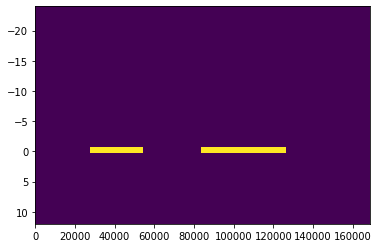

Wall time: 1.05 s


In [17]:
%%time
bin_cwt = np.zeros(cwt_vertical_filtered.shape)
for line_num in range(len(widths)):
    if count_frequency(widths[line_num]) in notes:
        for note_data in notes[count_frequency(widths[line_num])]:
            bin_cwt[line_num][note_data["start"]:note_data["end"]] = [1]*note_data["length"]

plt.imshow(bin_cwt, aspect='auto', interpolation='none',
            extent=[0, bin_cwt.shape[1]-1, widths[-1], widths[0]])
plt.show()

##  конвертируем в MIDI файл

In [18]:
import pretty_midi
from copy import deepcopy

def frequency_to_midi_number(frequency):
    #A4 - это №69
    return round(12*(np.log2(frequency) - np.log2(440.0)) + 69)

tempo = 130
MyMIDI = pretty_midi.PrettyMIDI(initial_tempo=tempo)
piano = pretty_midi.Instrument(program=0, is_drum=False, name='Acoustic Grand Piano')
MyMIDI.instruments.append(piano)

notes_s = deepcopy(notes) #ноты в секундах
for note_freq in notes_s.keys():
    for note_data in notes_s[note_freq]:
        note_data["start"] = round(note_data["start"] / SAMPLING_FREQUENCY, 6)
        note_data["end"] = round(note_data["end"] / SAMPLING_FREQUENCY, 6)
        note_data["length"] = round(note_data["length"] / SAMPLING_FREQUENCY, 6)

for note_freq in notes_s.keys():
    # Retrieve the MIDI note number for this note name
    note_number = frequency_to_midi_number(note_freq) #баг библиотеки
    for note_data in notes_s[note_freq]:
        # Create a Note instance for this note, starting at START seconds and ending at END seconds
        note = pretty_midi.Note(velocity=100, pitch=note_number-12, start=note_data["start"], end=note_data["end"])
        # Add it to our piano instrument
        piano.notes.append(note)

MyMIDI.write('result_midi.mid')
MyMIDI.write(folder+file_name+'_result.mid')

# Сравнение результатов с оригиналом

In [20]:
# прочитаем исходный миди
original_midi = pretty_midi.PrettyMIDI(folder+file_name+'.mid')
origin_notes = deepcopy(original_midi.instruments[0].notes)
my_notes = deepcopy(MyMIDI.instruments[0].notes)

def is_identical(note1, note2):
    return (note1.start == note2.start and 
            note1.end == note2.end and 
            note1.pitch == note2.pitch and 
            note1.velocity == note2.velocity)

def remove_duplicates(sorted_notes:list):
    note_idx = 0
    #проверяем на идентичность только соседние ноты, тк все отсортировано по старту
    while note_idx < len(sorted_notes)-1:
        if is_identical(sorted_notes[note_idx], sorted_notes[note_idx+1]):
            del(sorted_notes[note_idx])
        else:
            note_idx += 1

remove_duplicates(origin_notes)
remove_duplicates(my_notes)

origin_notes_amount = len(origin_notes)
my_notes_amount = len(my_notes)

origin_notes_pitched = {}
for note_data in origin_notes:
    if note_data.pitch not in origin_notes_pitched:
        origin_notes_pitched[note_data.pitch] = []
    origin_notes_pitched[note_data.pitch].append(note_data)

my_notes_pitched = {}
for note_data in my_notes:
    if note_data.pitch not in my_notes_pitched:
        my_notes_pitched[note_data.pitch] = []
    my_notes_pitched[note_data.pitch].append(note_data)

#нужно искать пересечения нот. я могу примерно доверять началам
# ключ: оригинальная нота.
# значение: нота из результата, которая с ней пересекается, если такая есть, иначе None.
paired_notes = {}
for note_data in origin_notes:
    paired_notes[note_data] = [] #массив на всякий случай. вдруг моя прога разобьет ноту на две

my_leftovers = [] #мои ноты, которым не нашлось места

def overlap(note1, note2) -> bool:
    if note2.start > note1.end or note1.start > note2.end:
        return False
    return True

for pitch in my_notes_pitched.keys():
    my_notes_of_one_pitch = my_notes_pitched[pitch]
    if pitch not in origin_notes_pitched.keys():
        my_leftovers.append(my_note)
        continue
    origin_notes_of_one_pitch = origin_notes_pitched[pitch]
    for my_note in my_notes_of_one_pitch:
        for origin_note in origin_notes_pitched[pitch]:
            if overlap(my_note, origin_note):
                paired_notes[origin_note].append(my_note)
                break
        else:
            #не нашли оригинальную пару для моей ноты
            my_leftovers.append(my_note)
        
print(f'Leftovers: {my_leftovers}')
#for note in paired_notes.keys(): print(f'Origin: {note}\nPair: {paired_notes[note]}\n')

#считаем метрики
amount_of_paired_notes = sum([1 if len(obj)>0 else 0 for obj in paired_notes.values()])
relative_amount_of_paired_notes = round(amount_of_paired_notes / origin_notes_amount * 100, 2)
print(f'Относительное количество нот, совпавших в распознаваемом и оригинальном произведениях: {relative_amount_of_paired_notes} %')

def calculate_relative_diff_start():
    res = 0
    for origin_note in paired_notes.keys():
        if len(paired_notes[origin_note])==0:
            continue
        origin_note_length = origin_note.end - origin_note.start
        diff_start = abs(origin_note.start - paired_notes[origin_note][0].start)
        res += diff_start/origin_note_length
    return res

relative_diff_start = round(calculate_relative_diff_start()/origin_notes_amount*100,2)
print(f'Среднее относительное отклонение времени начала звучания каждой ноты: {relative_diff_start} %')

def calculate_relative_diff_length():
    res = 0
    for origin_note in paired_notes.keys():
        if len(paired_notes[origin_note])==0:
            continue
        origin_note_length = origin_note.end - origin_note.start
        my_note_length = paired_notes[origin_note][0].end - paired_notes[origin_note][0].start
        diff_length = abs(origin_note_length - my_note_length)
        res += diff_length/origin_note_length
    return res

relative_diff_length = round(calculate_relative_diff_length()/origin_notes_amount*100,2)
print(f'Среднее относительное отклонение времени продолжительности звучания каждой ноты: {relative_diff_length} %')

relative_amount_of_recognized_notes = round(my_notes_amount/origin_notes_amount*100, 2)
print(f'Относительное количество распознанных нот: {relative_amount_of_recognized_notes} %')

amount_of_unrecognized_notes = sum([1 if len(obj)==0 else 0 for obj in paired_notes.values()])
relative_amount_of_unrecognized_notes = round(amount_of_unrecognized_notes / origin_notes_amount * 100, 2)
print(f'Относительное количество нераспознанных нот: {relative_amount_of_unrecognized_notes} %')


Leftovers: []
Относительное количество нот, совпавших в распознаваемом и оригинальном произведениях: 100.0 %
Среднее относительное отклонение времени начала звучания каждой ноты: 9.12 %
Среднее относительное отклонение времени продолжительности звучания каждой ноты: 23.58 %
Относительное количество распознанных нот: 100.0 %
Относительное количество нераспознанных нот: 0.0 %
